# **Maestría en Inteligencia Artificial Aplicada**
## **Curso: Inteligencia Artificial y Aprendizaje Automático**
### Tecnológico de Monterrey
### Prof Luis Eduardo Falcón Morales

## **Actividad de la Semana 6**
### **Árboles de decisión y bosque aleatorio.**


**Nombres y matrículas de los integrantes del equipo:**

*   
*   
*   
*   
*   


En cada sección deberás incluir todas las líneas de código necesarias para responder a cada uno de los ejercicios.

In [49]:
# Incluye aquí todos módulos, librerías y paquetes que requieras.
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler

# para poder aplicar operaciones matemáticas a los datos
from sklearn.compose import ColumnTransformer

# para poder imputar datos faltantes
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report, make_scorer

from imblearn.pipeline import make_pipeline

from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, validation_curve, learning_curve
from sklearn.model_selection import cross_validate

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
# %matplotlib inline


# **Ejercicio-1.** 

In [50]:
# leer los datos de del archivo
df = pd.read_csv('./SouthGermanCredit/SouthGermanCredit.asc', sep=' ')
df.head()

,laufkont,laufzeit,moral,verw,hoehe,sparkont,beszeit,rate,famges,buerge,...,verm,alter,weitkred,wohn,bishkred,beruf,pers,telef,gastarb,kredit
0,1,18,4,2,1049,1,2,4,2,1,...,2,21,3,1,1,3,2,1,2,1
1,1,9,4,0,2799,1,3,2,3,1,...,1,36,3,1,2,3,1,1,2,1
2,2,12,2,9,841,2,4,2,2,1,...,1,23,3,1,1,2,2,1,2,1
3,1,12,4,0,2122,1,3,3,3,1,...,1,39,3,1,2,2,1,1,1,1
4,1,12,4,0,2171,1,3,4,3,1,...,2,38,1,2,2,2,2,1,1,1


Carga los datos y sustituye los nombres de las columnas del alemán al inglés de acuerdo a como se indica en la página de la UCI.

In [51]:
# reemplazar encabezados del alemán al ingles
columns = {'laufkont': 'status', 'laufzeit': 'duration', 'moral': 'credit_history', 'verw': 'purpose', 'hoehe': 'amount',
           'sparkont': 'savings', 'beszeit': 'employment_duration', 'rate': 'installment_rate', 'famges': 'personal_status_sex',
           'buerge': 'other_debtors', 'wohnzeit': 'present_residence', 'verm': 'property', 'alter': 'age', 'weitkred': 'other_installment_plans',
           'wohn': 'housing', 'bishkred': 'number_credits', 'beruf': 'job', 'pers': 'people_liable', 'telef': 'telephone', 'gastarb': 'foreign_worker',
           'kredit': 'credit_risk'}
df.rename(columns=columns, inplace=True)
df.head()


,status,duration,credit_history,purpose,amount,savings,employment_duration,installment_rate,personal_status_sex,other_debtors,...,property,age,other_installment_plans,housing,number_credits,job,people_liable,telephone,foreign_worker,credit_risk
0,1,18,4,2,1049,1,2,4,2,1,...,2,21,3,1,1,3,2,1,2,1
1,1,9,4,0,2799,1,3,2,3,1,...,1,36,3,1,2,3,1,1,2,1
2,2,12,2,9,841,2,4,2,2,1,...,1,23,3,1,1,2,2,1,2,1
3,1,12,4,0,2122,1,3,3,3,1,...,1,39,3,1,2,2,1,1,1,1
4,1,12,4,0,2171,1,3,4,3,1,...,2,38,1,2,2,2,2,1,1,1


# **Ejercicio-2.**

Realiza una partición de los datos en el conjunto de entrenamiento del *85%* y el de prueba de *15%*. Los modelos se estarán entrenando con el método de validación cruzada, así que no es
necesario en este paso generar el conjunto de validación. Define como la variable X a todas las variables de entrada y a la variable Y como la variable de salida

In [52]:
y = df['credit_risk']
X = df.loc[:, df.columns != 'credit_risk']

X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.85, random_state=10)

print("X Entrenamiento", X_train.shape)
print("X val", X_val.shape)

print("Y Entrenamiento", y_train.shape)
print("Y val", y_val.shape)

X Entrenamiento (850, 20)
X val (150, 20)
Y Entrenamiento (850,)
Y val (150,)


In [53]:
# X = df.iloc[:, :-1]
# Y = df.iloc[:, -1] 

# XTrain, XTest, YTrain, YTest = train_test_split(X, Y, train_size=0.85, random_state=10)
# print("X Entrenamiento", XTrain.shape)
# print("X Prueba", XTest.shape)

# print("Y Entrenamiento", YTrain.shape)
# print("Y Prueba", YTest.shape)


# **Ejercicio-3.**

In [54]:
df.describe()

,status,duration,credit_history,purpose,amount,savings,employment_duration,installment_rate,personal_status_sex,other_debtors,...,property,age,other_installment_plans,housing,number_credits,job,people_liable,telephone,foreign_worker,credit_risk
count,1000.000000,1000.000000,1000.00000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,...,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,2.577000,20.903000,2.54500,2.828000,3271.24800,2.105000,3.384000,2.973000,2.68200,1.145000,...,2.358000,35.54200,2.675000,1.928000,1.407000,2.904000,1.845000,1.404000,1.963000,0.700000
std,1.257638,12.058814,1.08312,2.744439,2822.75176,1.580023,1.208306,1.118715,0.70808,0.477706,...,1.050209,11.35267,0.705601,0.530186,0.577654,0.653614,0.362086,0.490943,0.188856,0.458487
min,1.000000,4.000000,0.00000,0.000000,250.00000,1.000000,1.000000,1.000000,1.00000,1.000000,...,1.000000,19.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,1.000000,12.000000,2.00000,1.000000,1365.50000,1.000000,3.000000,2.000000,2.00000,1.000000,...,1.000000,27.00000,3.000000,2.000000,1.000000,3.000000,2.000000,1.000000,2.000000,0.000000
50%,2.000000,18.000000,2.00000,2.000000,2319.50000,1.000000,3.000000,3.000000,3.00000,1.000000,...,2.000000,33.00000,3.000000,2.000000,1.000000,3.000000,2.000000,1.000000,2.000000,1.000000
75%,4.000000,24.000000,4.00000,3.000000,3972.25000,3.000000,5.000000,4.000000,3.00000,1.000000,...,3.000000,42.00000,3.000000,2.000000,2.000000,3.000000,2.000000,2.000000,2.000000,1.000000
max,4.000000,72.000000,4.00000,10.000000,18424.00000,5.000000,5.000000,4.000000,4.00000,3.000000,...,4.000000,75.00000,3.000000,3.000000,4.000000,4.000000,2.000000,2.000000,2.000000,1.000000


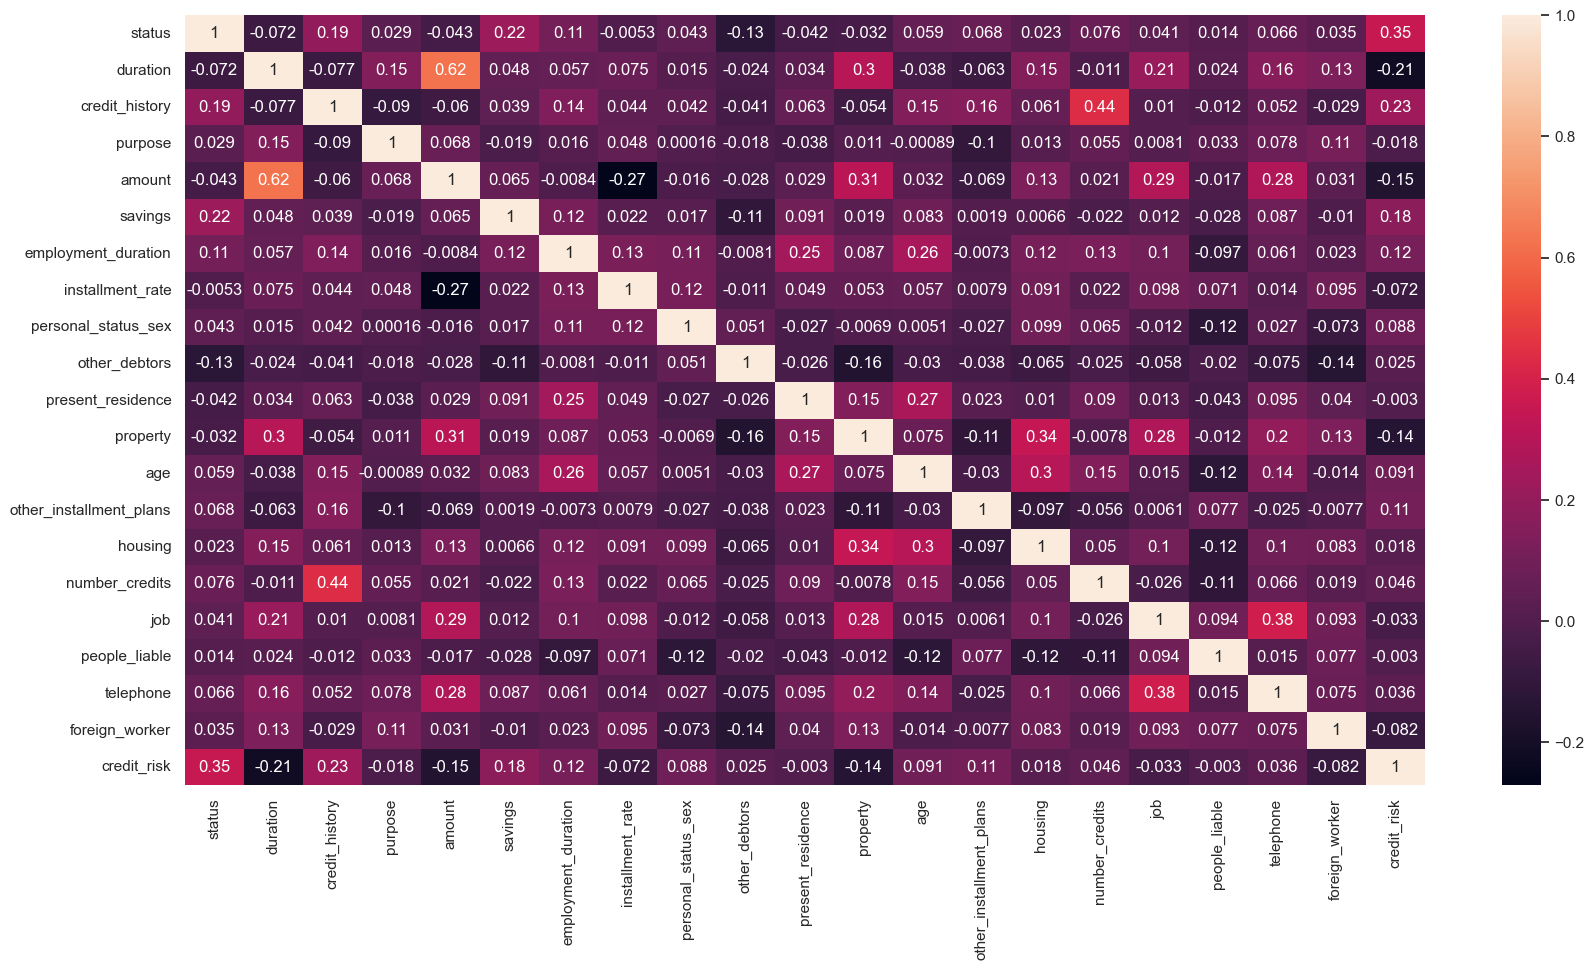

In [55]:
plt.figure(figsize=(20,10))
sns.heatmap(df.corr(), annot=True)
plt.show()

In [56]:
# categoricas = ['status', 'credit_history', 'purpose', 'savings', 'personal_status_sex', 'other_debtors', 'other_installment_plans', 'housing']
# # ordinales = ['employment_duration', 'installment_rate', 'present_residence', 'property', 'number_credits', 'job', 'people_liable']
# numeric = ['duration', 'amount', 'age']
# binary = ['telephone', 'foreign_worker']

# quantitative = [
#   'duration', 'amount', 'employment_duration', 'installment_rate', 'present_residence', 'age', 'number_credits', 'people_liable'
# ]
# onehot = [
#   'status', 'credit_history', 'purpose', 'savings', 'personal_status_sex', 
#   'other_debtors', 'other_installment_plans', 'housing', 'telephone', 'foreign_worker'
# ]

In [57]:
"""
b. Realiza un análisis de las variables numéricas (quantitative) de entrada y aplica una
   transformación que escale a todas ellas en un rango equiparable.
"""

quantitative = ['duration', 'amount', 'employment_duration', 'installment_rate', 'present_residence', 'age', 'number_credits', 'people_liable']
df_quantitative = df[quantitative]

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_quantitative.values)
df_scaled = pd.DataFrame(df_scaled, index=df_quantitative.index, columns=df_quantitative.columns)

# plt.figure(figsize=(7,4))
# sns.heatmap(df_scaled.corr(), annot=True)
# plt.show()

"""
Aplica la transformación One-Hot encoding a las variables de entrada de tipo categórico y
binaria. En particular, justifica por qué una variable binaria requeriría que se le aplique la
transformación one-hot encoding. Por el momento dejar las variables ordinales sin
transformar
"""

categoric_binary = ['status', 'credit_history', 'purpose', 'savings', 'other_debtors', 'other_installment_plans', 'housing', 
'people_liable', 'telephone', 'foreign_worker']
df_category_binary = df[categoric_binary]

# pd.get_dummies(df_category_binary.columns)

enc = OneHotEncoder(categories='auto', handle_unknown='ignore')
onehots = enc.fit(df_category_binary)
onehot_matrix = enc.transform(df_category_binary).toarray()
# onehot_matrix.shape

# df_scaled.head()

In [58]:
# crear pipeline para columnas numéricas/cuantitativas

"""
b. Realiza un análisis de las variables numéricas (quantitative) de entrada y aplica una transformación que escale a todas ellas en un rango equiparable.
"""
numeric_pipeline = Pipeline(steps=[
  ('imputacionMediana', SimpleImputer(strategy='median')),
  ('escalado',          StandardScaler())
])
quantitative = ['duration', 'amount', 'employment_duration', 'installment_rate', 'present_residence', 'age', 'number_credits', 'people_liable']


"""
a. Imputación a todas las variables de entrada, diferenciando entre el tipo de cada variable (decide y justifica que tipo de imputación realizas en cada caso).
"""
categorical_pipeline = Pipeline(steps=[
  ('imputacionModa', SimpleImputer(strategy='most_frequent')),
])
categorical = ['status', 'credit_history', 'purpose', 'savings', 'personal_status_sex', 'other_debtors', 'other_installment_plans', 'housing']


"""
c. Aplica la transformación One-Hot encoding a las variables de entrada de tipo categórico y binaria. 
En particular, justifica por qué una variable binaria requeriría que se le aplique la transformación one-hot encoding. 
Por el momento dejar las variables ordinales sin transformar.
"""
oneHot_pipeline = Pipeline(steps=[
  ('oneHot', OneHotEncoder(drop='first'))
])
categoric_binary = ['status', 'credit_history', 'purpose', 'savings', 'other_debtors', 'other_installment_plans', 'housing', 'people_liable', 'telephone', 'foreign_worker']

column_transformer = ColumnTransformer(
  transformers=[
    ('numeric',       numeric_pipeline,      quantitative),
    ('categoric',     categorical_pipeline,  categorical),
    ('oneHotEncoder', oneHot_pipeline,       categoric_binary),
  ],
  remainder='passthrough'
)



# **Ejercicio-4.**

### Definición de funciones para evaluar los modelos

In [59]:
def my_accuracy(y_real, y_pred):
  """
  Calcula la accuracy del modelo
  y_real: valores reales
  y_pred: valores predichos
  """
  vn, fp, fn, vp = confusion_matrix(y_real, y_pred).ravel()
  return (vp + vn) / (vp + fp + fn + vn)


def my_precision(y_real, y_pred):
  """
  Calcula la precisión del modelo
  y_real: valores reales
  y_pred: valores predichos
  """
  vn, fp, fn, vp = confusion_matrix(y_real, y_pred).ravel()

  return vp / (vp + fp)


def my_recall(y_real, y_pred):
  """
  Calcula recall de un modelo
  y_real: valores reales
  y_pred: valores predichos
  """
  vn, fp, fn, vp = confusion_matrix(y_real, y_pred).ravel()
  return vp / (vp + fn)


def my_f1score(y_real, y_pred):
  """
  Calcula el f1score de un modelo
  y_real: valores reales
  y_pred: valores predichos
  """
  vn, fp, fn, vp = confusion_matrix(y_real, y_pred).ravel()
  return 2 * vp / (2 * vp + fp + fn)


def my_gmean(y_real, y_pred):
  """
  Calcula el geometric mean de un modelo
  y_real: valores reales
  y_pred: valores predichos
  """
  vn, fp, fn, vp = confusion_matrix(y_real, y_pred).ravel()

  recall = vp / (vp + fn)
  especificidad = vn / (vn+fp)

  gmean = np.sqrt(recall * especificidad)

  return gmean


In [60]:
modelos, nombres = [], []

modelos.append(LogisticRegression(max_iter=1000))
nombres.append('Regresión Logística')

modelos.append(DecisionTreeClassifier())
nombres.append('Árbol de Decisión')

modelos.append(RandomForestClassifier())
nombres.append('Random Forest')



In [61]:
from sklearn.base import TransformerMixin, BaseEstimator

class Debug(BaseEstimator, TransformerMixin):
  def transform(self, X):
    print(pd.DataFrame(X).head())
    print(X.shape)
    return X
  
  def fit(self, X, y=None, **fit_params):
    return self
    

In [62]:

resultados = [] 

print("Modelo\t\tMEANS\tACCUR\tPRES\tRECALL\tF1\tGMEAN")
for i in range(len(modelos)):
  
  pipe = make_pipeline((column_transformer), (modelos[i]))
  cross_validation = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
  my_metrics = {
    'accuracy': make_scorer(my_accuracy),
    'precision': make_scorer(my_precision),
    'recall': make_scorer(my_recall),
    'f1score': make_scorer(my_f1score),
    'gmean': make_scorer(my_gmean)
  }

  # MNA_IAyAA_semana_5_clases_no_balanceadas.ipynb
  # Recuerda que este proceso de cross_validate con CV, separa
  # internamente Train y Val para evitar el filtrado de información.  
  # scores = cross_validate(pipe, X_train, y_train, scoring=my_metrics, cv=cross_validation, n_jobs=-1)
  scores = cross_validate(pipe, X, y, scoring=my_metrics, cv=cross_validation, n_jobs=-1)
  resultados.append(scores)

  print("%-20s\t%.4f\t%.4f\t%.4f\t%.4f\t%.4f" % (
    nombres[i],
    np.mean(scores['test_accuracy']), 
    np.mean(scores['test_precision']),
    np.mean(scores['test_recall']),
    np.mean(scores['test_f1score']),
    np.mean(scores['test_gmean'])  
  ))



Modelo		MEANS	ACCUR	PRES	RECALL	F1	GMEAN
Regresión Logística 	0.7607	0.7993	0.8800	0.8372	0.6492
Árbol de Decisión   	0.6887	0.7830	0.7686	0.7754	0.6200
Random Forest       	0.7633	0.7914	0.9005	0.8418	0.6284


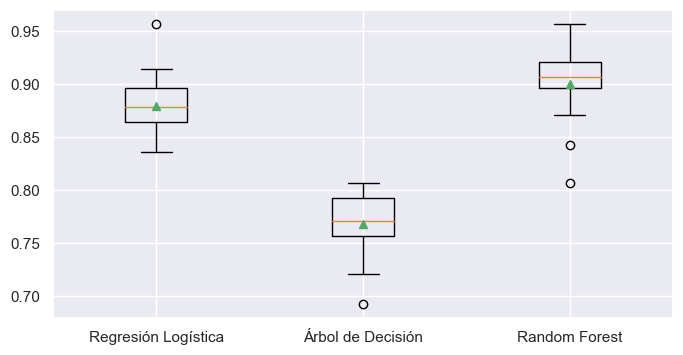

In [63]:
sns.set(rc={'figure.figsize':(8,4)})
boxPlotsRecall = list()
for i in range(len(resultados)):
  rr = resultados[i]['test_recall']
  boxPlotsRecall.append(rr)

plt.boxplot(boxPlotsRecall, labels=nombres, showmeans=True)
plt.show()

### Curvas

In [64]:
def mi_LearningCurvePlot(train_sizes, train_scores, val_scores, title=None, xlabel=None, ylabel=None):

    # Argumentos de entrada de la función mi_LearningCurvePlot:
    #      train_sizes : número de observaciones en el conjunto de entrenamiento.
    #      train_scores : Exactitud de cada partición en el proceso de Validación-Cruzada (VC) en los datos de entrenamiento.
    #                     La dimensión de este conjunto es (pxq) 
    #                                     donde p="número de particiones de manera incremental del conjunto de entrenamiento".
    #                                           q="número de particiones de VC" * "número de repeticiones de VC con RepitedStratifiedCV"
    #      val_scores : Exactitud de cada partición en el proceso de Validación-Cruzada en los datos de validación.
    #                   Es de la misma dimensión que los train_scores. 
    # Output: la salida es el gráfico con las curvas de aprendizaje.

    # Obtenemos los promedios y desviaciones estándar de cada renglón de los resultados de entrenamiento y validación
    # La dimensión de cada uno es p="número de particiones de manera incremental del conjunto de entrenamiento".
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)

    # Gráfica las curvas de aprendizaje incluyendo una región indicando la desviación estándar.
    plt.figure(figsize=(7,6))    
    plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training')
    plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.1, color='blue')
    
    plt.plot(train_sizes, val_mean, color='red', marker='+', markersize=5, linestyle='--', label='Validation')
    plt.fill_between(train_sizes, val_mean + val_std, val_mean - val_std, alpha=0.1, color='red')
    
    if title:
        plt.title(title)
    
    if xlabel:
        plt.xlabel(xlabel)
    
    if ylabel:
        plt.ylabel(ylabel)
        
    # plt.grid()
    plt.legend(loc='lower left')
    plt.show()

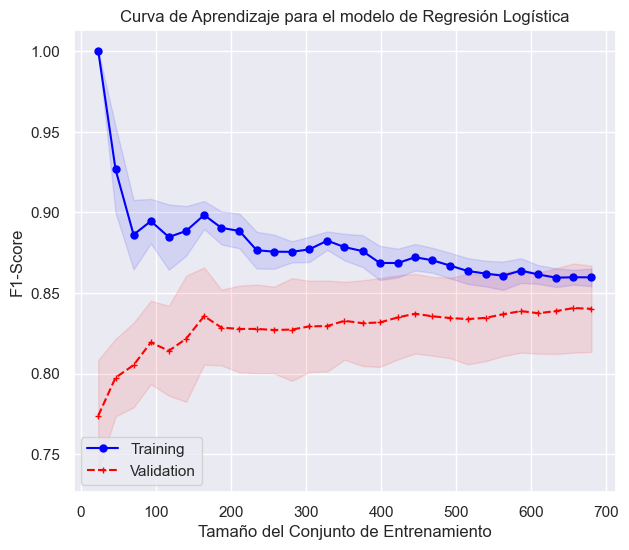

In [87]:
delta_C = np.linspace(0.0001, 1.0, 30),

X_train_transformed = column_transformer.fit_transform(X_train)
cvLC = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

model = LogisticRegression(max_iter=1000, random_state=42)
train_sizes, train_scores, test_scores = learning_curve(
    model,
    X_train_transformed,
    np.ravel(y_train),
    train_sizes=delta_C,
    cv=cvLC,
    scoring=make_scorer(my_f1score),
    n_jobs=-1
    # scoring="f1"
)

mi_LearningCurvePlot(train_sizes, train_scores, test_scores,
                     title="Curva de Aprendizaje para el modelo de Regresión Logística",
                     xlabel="Tamaño del Conjunto de Entrenamiento",
                     ylabel="F1-Score"
                    )


[ 1  1  2  2  3  4  4  5  6  6  7  8  8  9 10 10 11 12 12 13 14 14 15 16
 16 17 18 18 19 20]


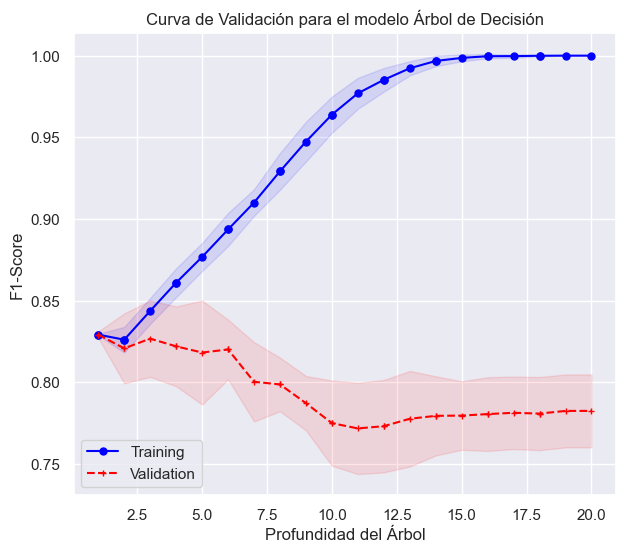

In [88]:
# importante que sea int
delta_D = np.linspace(1, 20, 20, dtype=int)
print(delta_D)

cvLC = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
X_train_transformed = column_transformer.fit_transform(X_train)

model = DecisionTreeClassifier(random_state=42)
train_scores, test_scores = validation_curve(
    model,
    X_train_transformed,
    np.ravel(y_train),
    param_name="max_depth",
    param_range=delta_D,
    cv=cvLC,
    scoring=make_scorer(my_f1score),
    n_jobs=-1,
    error_score="raise"
)

mi_LearningCurvePlot(delta_D, train_scores, test_scores,
                     title="Curva de Validación para el modelo Árbol de Decisión",
                     xlabel="Profundidad del Árbol",
                     ylabel="F1-Score"
                    )

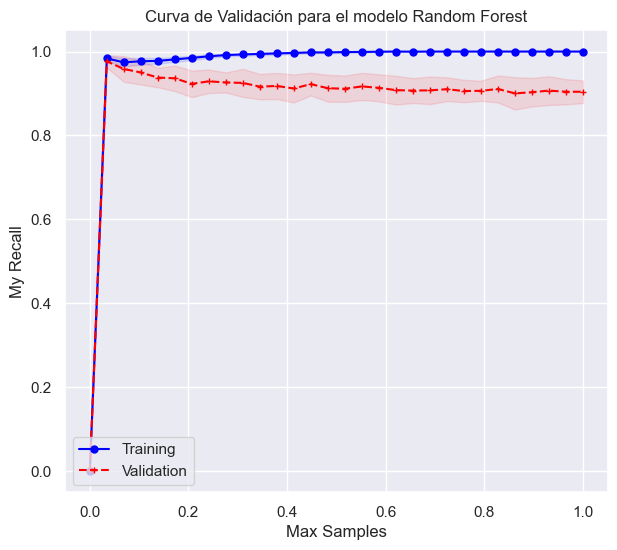

In [89]:
delta_S = np.linspace(0.0001, 1, 30)
cvLC = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
X_train_transformed = column_transformer.fit_transform(X_train)

model = RandomForestClassifier(random_state=42)
train_scores, test_scores = validation_curve(
    model,
    X_train_transformed,
    np.ravel(y_train),
    param_name="max_samples",
    param_range=delta_S,
    cv=cvLC,
    scoring=make_scorer(my_recall),
    n_jobs=-1,
    error_score="raise"
)

mi_LearningCurvePlot(delta_S, train_scores, test_scores,
                     title="Curva de Validación para el modelo Random Forest",
                     xlabel="Max Samples",
                     ylabel="My Recall"
                    )

#**Ejercicio-5.**

In [68]:
None

#**Ejercicio-6.**

In [69]:
None

###**Fin de la Actividad de la semana 6.**